## MLFLOW для экспериментов с PyTorch

__Как запустить сервер:__

Команды терминала:

Включим нужное окружение conda:

>conda activate "название окружения conda"

Запустим сервер:

>mlflow server --backend-store-uri "папка на компьютере, где будут храниться результаты" --default-artifact-root "папка на компьютере, где будут храниться артефакты"

В конце можно добавить нужный порт (автоматом 5000) --host localhost --port 5000

пример:
>mlflow server --backend-store-uri "file:///C:/ML_flow_server/data_local" --default-artifact-root "file:///C:/ML_flow_server/artefacts" --host localhost --port 5000


По этой ссылке будет доступен MLflow:

http://localhost:5000

In [1]:
import os
import random
import logging

import torch
import mlflow
import numpy as np # библиотека работы с матрицами на цпу
import matplotlib.pyplot as plt # библиотека для отображения графиков и изображений
import torchvision.transforms as transforms
import torchvision.utils
import torch.nn as nn

%matplotlib inline

In [2]:
# Укажем юзера который делает эксперименты
os.environ['USER'] = 'Dima Kolesnikov'

In [3]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, 
                                                transform=transforms.Compose([transforms.ToTensor()]),  
                                                download=True)
val_mnist = torchvision.datasets.MNIST('data_mnist/test', train=False, 
                                               transform=transforms.Compose([transforms.ToTensor()]), 
                                               download=True)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_mnist,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_mnist,
                batch_size=batch_size,
                shuffle=False)

__Создадаим fc сеть:__

In [5]:
class FCNetwork(nn.Module):
    def __init__(self, prob, n_inside):
        super(FCNetwork, self).__init__() 
        self.fc1 = nn.Linear(784, n_inside)
        self.fc2 = nn.Linear(n_inside, 10)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p = prob)

    def forward(self,x):
        x = x.view(-1,28*28)
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

## Пример без MLFlow:

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FCNetwork(prob=0.5, n_inside=100)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Функция для вычисления точности
def accuracy(y_pred, labels):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == labels).float().mean().item()

Обучим сеть как обычно это делаем без трекинга в mlflow. Загружать будем локально на компьютер лучшую модель с мах test accuracy

In [7]:
maxacc = 0
N_epochs = 5

for epoch in range(N_epochs):
    epoch += 1
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_samples = 0

    for itr, data in enumerate(train_loader):
        imgs = data[0].to(device)  # [B, H, W]
        labels = data[1].to(device)

        y_pred = model(imgs)  
        loss = loss_func(y_pred, labels)

        train_loss += loss.item() * imgs.size(0)
        train_acc += accuracy(y_pred, labels) * imgs.size(0)
        train_samples += imgs.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= train_samples
    train_acc /= train_samples
    print(f'The {epoch} Epoch of network learning is over:')
    print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_samples = 0

    with torch.no_grad():
        for itr, data in enumerate(val_loader):
            imgs = data[0].to(device)
            labels = data[1].to(device)
            y_pred = model(imgs)
            loss = loss_func(y_pred, labels)

            val_loss += loss.item() * imgs.size(0)
            val_acc += accuracy(y_pred, labels) * imgs.size(0)
            val_samples += imgs.size(0)

    val_loss /= val_samples
    val_acc /=val_samples
    print(f'Validation results Epoch {epoch}: Val loss - {val_loss:.4f}, Val accuracy - {val_acc:.4f}')

    if val_acc > maxacc:
        print('Saving model because its better')
        maxacc = val_acc
        torch.save(model, f'mymodel_fc.pth')
    print('---')

The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 1.6956, Train accuracy - 0.6011
Validation results Epoch 1: Val loss - 1.0384, Val accuracy - 0.8214
Saving model because its better
---
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 0.8647, Train accuracy - 0.8079
Validation results Epoch 2: Val loss - 0.6138, Val accuracy - 0.8694
Saving model because its better
---
The 3 Epoch of network learning is over:
Train results Epoch 3: Train loss - 0.6273, Train accuracy - 0.8372
Validation results Epoch 3: Val loss - 0.4750, Val accuracy - 0.8885
Saving model because its better
---
The 4 Epoch of network learning is over:
Train results Epoch 4: Train loss - 0.5404, Train accuracy - 0.8497
Validation results Epoch 4: Val loss - 0.4102, Val accuracy - 0.8973
Saving model because its better
---
The 5 Epoch of network learning is over:
Train results Epoch 5: Train loss - 0.4925, Train accuracy - 0.8594
Validation results Epoch 5: Val los

---

## Теперь воспользуемся MLFlow для трекинга экспериментов:

In [8]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("PyTorch_test")

<Experiment: artifact_location='file:///C:/ML_flow_server/artefacts/419035600050725895', creation_time=1730706849000, experiment_id='419035600050725895', last_update_time=1730706849000, lifecycle_stage='active', name='PyTorch_test', tags={}>

In [9]:
# Отключаем вывод ворнингов от MLflow
mlflow_logger = logging.getLogger("mlflow")
mlflow_logger.setLevel(logging.ERROR)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prob = 0.15
n_inside = 50
lr = 1e-4
epochs = 15

In [11]:
# Начало MLflow запуска
with mlflow.start_run(run_name='FCNetwork_1') as run:
    model = FCNetwork(prob=prob, n_inside=n_inside)
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mlflow.log_param("prob dropout", prob)
    mlflow.log_param("neurons 2 layer", n_inside)
    mlflow.log_param("lr", lr)
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("epochs", epochs)

    maxacc = 0
    itr_record = 0

    for epoch in range(epochs):
        epoch += 1
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_samples = 0

        print(f'Началось обучение {epoch} эпохи')
        for itr, data in enumerate(train_loader):
            imgs = data[0].to(device)  # [B, H, W]
            labels = data[1].to(device)

            y_pred = model(imgs) 
            loss = loss_func(y_pred, labels)

            train_loss += loss.item() * imgs.size(0)
            train_acc += accuracy(y_pred, labels) * imgs.size(0)
            train_samples += imgs.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= train_samples
        train_acc /= train_samples
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        print(f'The {epoch} Epoch of network learning is over:')
        print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_samples = 0

        with torch.no_grad():
            for itr, data in enumerate(val_loader):
                imgs = data[0].to(device)
                labels = data[1].to(device)
                y_pred = model(imgs)
                loss = loss_func(y_pred, labels)

                val_loss += loss.item() * imgs.size(0)
                val_acc += accuracy(y_pred, labels) * imgs.size(0)
                val_samples += imgs.size(0)

        val_loss /= val_samples
        val_acc /= val_samples
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        print(f'Validation results Epoch {epoch}: Val loss - {val_loss:.4f}, Test accuracy - {val_acc:.4f}')

        if val_acc > maxacc:
            print('Saving model because its better')
            maxacc = val_acc
            mlflow.pytorch.log_model(model, "model")
        print('---')

    print('max accuracy = ', maxacc)
    mlflow.log_metric("max val accuracy", maxacc)

mlflow.end_run()

Началось обучение 1 эпохи
The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 1.7878, Train accuracy - 0.5810
Validation results Epoch 1: Val loss - 1.2519, Test accuracy - 0.7852
Saving model because its better
---
Началось обучение 2 эпохи
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 0.9821, Train accuracy - 0.8149
Validation results Epoch 2: Val loss - 0.7451, Test accuracy - 0.8519
Saving model because its better
---
Началось обучение 3 эпохи
The 3 Epoch of network learning is over:
Train results Epoch 3: Train loss - 0.6670, Train accuracy - 0.8533
Validation results Epoch 3: Val loss - 0.5537, Test accuracy - 0.8770
Saving model because its better
---
Началось обучение 4 эпохи
The 4 Epoch of network learning is over:
Train results Epoch 4: Train loss - 0.5336, Train accuracy - 0.8708
Validation results Epoch 4: Val loss - 0.4613, Test accuracy - 0.8906
Saving model because its better
---
Началось обучение 5 эпохи
The 5 Epoc

---

## Запуск обученной модели:

In [12]:
def load_model(model_uri):
    """Загрузка модели из MLflow."""
    model = mlflow.pytorch.load_model(model_uri)
    model.eval()  # Переводим модель в режим оценки
    return model

def predict(model, input_data):
    """Выполнение инференса."""
    with torch.no_grad():
        output = model(input_data)
    return output

In [13]:
model_uri = "runs:/ef937515149145ddbfb16b90e3e71b20/model"  # Замените <run_id> на реальный идентификатор запуска
loaded_model = load_model(model_uri).to(device)
loaded_model.eval()

# Пример входных данных
input_data = torch.randn(1, 1, 28, 28).to(device)

# Выполнение инференса
output = predict(loaded_model, input_data)
print(output)

tensor([[ 1.5928,  1.1507,  4.4580, -0.3509, -4.3244,  0.7749,  0.1126, -6.8168,
          1.2436, -6.6594]], device='cuda:0')


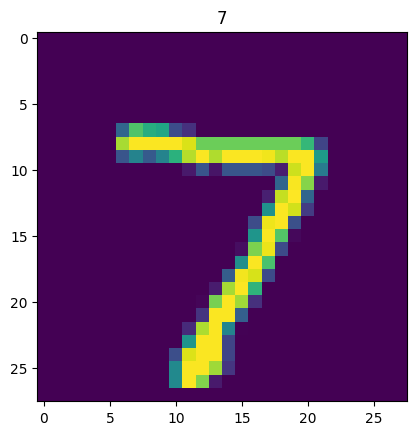

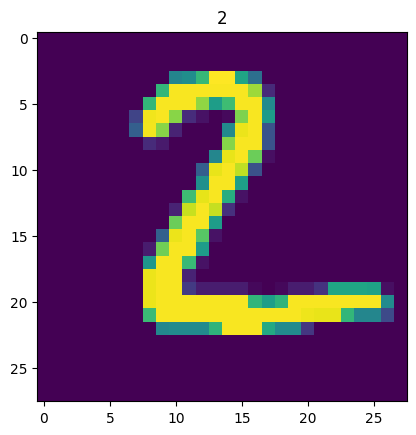

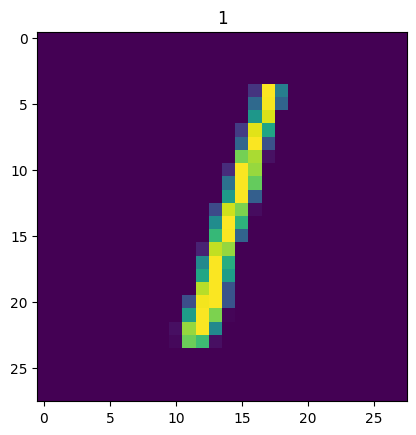

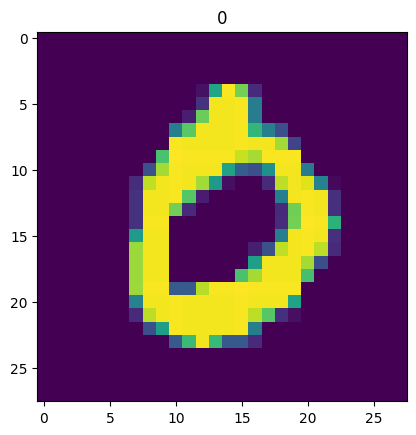

In [14]:
with torch.no_grad():
    for itr,data in enumerate(val_loader):
        if itr == 0:
            imgs = data[0].to(device)   #b,c,w,h
            labels = data[1].to(device)
            y_pred = predict(loaded_model, imgs)
            y_pred = torch.argmax(y_pred, dim=1)
            for i in range(4):
                im = np.transpose((imgs[i].cpu().numpy()), (1, 2, 0))
                plt.figure()
                plt.imshow(im)  #w,h,c
                plt.title(y_pred[i].cpu().numpy())
                plt.show()

___